In [104]:
!pip install -U langchain-ollama langchain-openai

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
!ls /content/drive/MyDrive/review_dataset

ls: cannot access '/content/drive/MyDrive/review_dataset': No such file or directory


In [107]:
import duckdb

con = duckdb.connect(database=':memory:', read_only=False)

In [108]:
df = con.execute("SELECT * FROM read_csv_auto('/content/drive/MyDrive/reviwe-dataset/w_review_train.csv', parallel=false, encoding='UTF-8', ignore_errors=true)").fetchdf()

df.head()

,column0,column1
0,ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้...,3
1,อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา...,4
2,ปอเปี๊ยะสด ทุกวันนี้รู้สึกว่าหากินยาก (ร้านที่...,3
3,รัานคัพเค้กในเมืองไทยมีไม่มาก หลายๆคนอาจจะสงสั...,5
4,อร่อย!!! เดินผ่านDigital gatewayทุกวัน ไม่ยักร...,5


In [109]:
df.shape

(40000, 2)

In [110]:
con.execute("COPY df TO '/content/drive/MyDrive/reviwe-dataset/w_review_train1.parquet' (FORMAT PARQUET)")

ค้นหาจากคำว่า "ดี"

In [111]:
parquet_avg_rating_direct = con.execute("SELECT AVG(column1) FROM '/content/drive/MyDrive/reviwe-dataset/w_review_train1.parquet' WHERE column0 LIKE '%ดี%'").fetchone()[0]
parquet_avg_rating_direct

3.7314021487828097

In [112]:
parquet_file_path = '/content/drive/MyDrive/reviwe-dataset/w_review_train1.parquet'

In [113]:
parquet_avg_rating_direct = con.execute(f"SELECT AVG(column1) FROM '{parquet_file_path}' WHERE column0 LIKE '%ดี%'").fetchone()[0]
parquet_avg_rating_direct

3.7314021487828097

คำค้นหาจากอาหารต่างๆ

In [114]:
food_keywords = [
    'อาหาร', 'ของกิน', 'กินข้าว', 'ร้านอาหาร', 'เมนู', 'จานเด็ด',
    'ข้าว', 'กับข้าว', 'กับข้าวอร่อย', 'อร่อย', 'รสชาติ', 'รสชาติดี',
    'อาหารไทย', 'อาหารญี่ปุ่น', 'อาหารจีน', 'อาหารเกาหลี', 'อาหารฝรั่ง',
    'อาหารทะเล', 'อาหารซีฟู้ด', 'ก๋วยเตี๋ยว', 'ข้าวมันไก่',
    'ชาบู', 'ปิ้งย่าง', 'หมูกระทะ', 'ซูชิ', 'ราเมน', 'ข้าวแกงกะหรี่',
    'ข้าวผัด', 'ผัดไทย', 'ต้มยำ', 'แกง', 'ของหวาน', 'ของคาว',
    'เบอร์เกอร์', 'พิซซ่า', 'สเต็ก', 'สลัด', 'ซุป', 'ของทอด',
    'ของปิ้งย่าง', 'เมนูอาหาร', 'ร้านอาหารไทย', 'ร้านอาหารญี่ปุ่น',
    'อาหารจานเดียว', 'บุฟเฟ่ต์', 'อาหารอร่อย'
]

where_clause = " OR ".join([f"column0 LIKE '%{keyword}%'" for keyword in food_keywords])

In [115]:
%%time
food_reviews_df = con.execute(f"SELECT * FROM '{parquet_file_path}' WHERE {where_clause}").fetchdf()

CPU times: user 902 ms, sys: 33.3 ms, total: 935 ms
Wall time: 1.11 s


In [116]:
csv_file_path = '/content/drive/MyDrive/reviwe-dataset/w_review_train.csv'

In [117]:
%%time
food_reviews_df_csv = con.execute(f"SELECT * FROM read_csv_auto('{csv_file_path}', parallel=false, encoding='UTF-8', ignore_errors=true) WHERE {where_clause}").fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 3.17 s, sys: 75.4 ms, total: 3.24 s
Wall time: 5.19 s


In [118]:
food_reviews_df.head()

,column0,column1
0,ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้...,3
1,อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา...,4
2,ปอเปี๊ยะสด ทุกวันนี้รู้สึกว่าหากินยาก (ร้านที่...,3
3,รัานคัพเค้กในเมืองไทยมีไม่มาก หลายๆคนอาจจะสงสั...,5
4,อร่อย!!! เดินผ่านDigital gatewayทุกวัน ไม่ยักร...,5


In [119]:
food_reviews_df.shape

(38003, 2)

In [120]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [121]:
!nohup ollama serve &

nohup: appending output to 'nohup.out'


In [122]:

!ollama pull gemma3:270m

In [123]:
!ollama list

NAME                                  ID              SIZE      MODIFIED               
gemma3:270m                           e7d36fb2c3b3    291 MB    Less than a second ago    
scb10x/typhoon2.1-gemma3-4b:latest    8cfab9097c9d    2.6 GB    12 minutes ago            


In [124]:
!ollama run gemma3:270m "สวัสดีจ้า"

สวัสดีค่ะ ยินดีที่ได้รู้จักค่ะ 😊




In [125]:
!curl -s http://127.0.0.1:11434/api/tags

{"models":[{"name":"gemma3:270m","model":"gemma3:270m","modified_at":"2025-10-19T12:11:02.452146439Z","size":291554930,"digest":"e7d36fb2c3b3293cfe56d55889867a064b3a2b22e98335f2e6e8a387e081d6be","details":{"parent_model":"","format":"gguf","family":"gemma3","families":["gemma3"],"parameter_size":"268.10M","quantization_level":"Q8_0"}},{"name":"scb10x/typhoon2.1-gemma3-4b:latest","model":"scb10x/typhoon2.1-gemma3-4b:latest","modified_at":"2025-10-19T11:58:42.420816348Z","size":2615662352,"digest":"8cfab9097c9d142fa16c7556826c9a7874f4642ac6d575e2d66a4f4979c48b76","details":{"parent_model":"","format":"gguf","family":"gemma3","families":["gemma3"],"parameter_size":"3.9B","quantization_level":"Q4_K_M"}}]}

In [126]:
from langchain_ollama import OllamaLLM

In [127]:
from langchain_core.output_parsers import StrOutputParser

In [128]:
from langchain_core.prompts import PromptTemplate

In [129]:
llm = OllamaLLM(model="gemma3:270m")

In [130]:
response = llm.invoke("สวัสดี")
print(response)

สวัสดีค่ะ ยินดีที่ได้รู้จักค่ะ 😊



In [131]:
template = """
คุณเป็นครูสอน Python
คำถาม : {question}
"""

In [132]:
prompt = PromptTemplate(
    input_variables=["question"],
    template=template
)

In [133]:
formatted_prompt = prompt.format(question="เขียนโค้ดหาผลรวมของตัวเลข 1 ถึง 10")
print(formatted_prompt)


คุณเป็นครูสอน Python
คำถาม : เขียนโค้ดหาผลรวมของตัวเลข 1 ถึง 10



In [134]:
chain = prompt | llm

In [135]:
response = chain.invoke({"question": "เขียนโค้ดหาผลรวมของตัวเลข 1 ถึง 10"})

In [136]:
response

'แน่นอนครับ! ผมจะช่วยคุณเขียนโค้ด Python เพื่อหาผลรวมของตัวเลข 1 ถึง 10 ครับ\n'

In [137]:
from IPython.display import display, Markdown

In [138]:
display(Markdown(response))

แน่นอนครับ! ผมจะช่วยคุณเขียนโค้ด Python เพื่อหาผลรวมของตัวเลข 1 ถึง 10 ครับ


In [139]:
prompt1 = PromptTemplate(
    template="แปลโจทย์เกี่ยวกับ {question}"
)

chain1 = prompt1 | llm

In [140]:
prompt2 = PromptTemplate(
    template="ทำความเข้าใจโจทย์ที่แปลแล้วต่อไปนี้ {translate}"
)

chain2 = prompt2 | llm

In [141]:
prompt3 = PromptTemplate(
    template="แก้โจทย์ตามที่เข้าใจต่อไปนี้ {understand}"
)

chain3 = prompt3 | llm

In [142]:
prompt4 = PromptTemplate(
    template="อธิบายวิธิีทำจากผลลัทธ์ต่อไปนี้ {solve}"
)

chain4 = prompt4 | llm

In [143]:
parser_chain = StrOutputParser()

In [144]:
full_chain = chain1 | chain2 | chain3 | chain4 | parser_chain

In [145]:
result = full_chain.invoke({"question":"2x + 5 = 15"})

In [146]:
result

'ถูกต้องแล้วครับ'

In [147]:
display(Markdown(result))

ถูกต้องแล้วครับ

In [148]:
import os
from langchain_openai import ChatOpenAI

In [149]:
OPENAI_API_KEY = "123456789"

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [150]:
llm2 = ChatOpenAI(model="gpt-4o-mini")

In [151]:
chain1 = prompt1 | llm2
chain2 = prompt2 | llm2
chain3 = prompt3 | llm2
chain4 = prompt4 | llm2

full_chain = chain1 | chain2 | chain3 | chain4 | parser_chain

In [152]:
keyword_prompt = PromptTemplate(
template = """
จาก Review ต่อไปนี้
Extract 3 keywords ที่เป็นตัวแทนของ Review นี้

Review: {review}

ขั้นตอนการ Extract keywords
1. อ่านรีวิวและเข้าใจความหมาย
2. ระบุหัวข้อหลักที่กล่าวถึง
3. เลือก 3 keywords ที่สำคัญที่สุด
4. ตอบในรูปแบบ JSON โดยมี key คือ keywords เช่น{{"keywords": "คำ1, คำ2, คำ3"}}

ให้ทำทีละขั้นตอน
""")

In [153]:
sample_reviews = food_reviews_df['column0'].head(2)
sample_reviews

,column0
0,ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้...
1,อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา...


In [154]:
sample_reviews.to_csv('/content/sample_reviews.csv', index=False)

In [155]:
keyword_extract = keyword_prompt | llm | StrOutputParser()

In [156]:
%%time
results = []
for review in sample_reviews:
    text = keyword_extract.invoke({"review": review})
    cleaned = (text).replace("**", "").strip()
    results.append({"review": review, "text": cleaned})

CPU times: user 118 ms, sys: 8.13 ms, total: 126 ms
Wall time: 14.7 s


In [157]:
for result in results:
    print(f"Review {result['review'][:1000]}...")
    print(f"text {result['text']}\n")

Review ร้านอาหารใหญ่มากกกกกกก 
เลี้ยวเข้ามาเจอห้องน้ำก่อนเลย เออแปลกดี 
ห้องทานหลักๆอยู่ชั้น 2 มีกาแฟ น้ำผึ้ง ซึ่งก็แค่เอาน้ำผึ้งมาราด แพงเวอร์ อย่าสั่งเลย 
ลาบไข่ต้ม ไข่มันคาวอะ เลยไม่ประทับใจเท่าไหร่
ทอดมันหัวปลีกรอบอร่อยต้องเบิ้ล 
พะแนงห่อไข่อร่อยดี เห้ยแต่ราคา 150บาทมันเกินไปนะ รับไม่ไหวว
เลิกกินแล้วมีขนมหวานให้กินฟรีเล็กน้อย )ขนมไทย) 

คงไม่ไปซ้ำ แพงเกิน ...
text ```json
{
  "keywords": [
    "ร้านอาหารใหญ่",
    "ห้องน้ำ",
    "กาแฟ",
    "น้ำผึ้ง",
    "ละอองไข่ต้ม",
    "ไข่มันคาว",
    "ขนมไทย",
    "ขนมหวาน",
    "ฟรี",
    "ราคา",
    "เลิกกิน",
    "ขนมหวานให้กินฟรี"
  ]
}
```

Review อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา ตัวร้านตั้งอยู่ที่ถนนพุทธมณฑลสาย 3 ไปตาม ถ.ปิ่นเกล้า-นครชัยศรี เมื่อถึงพุทธมณฑลสาย 3 ก็เลี้ยวเข้าไปประมาณ 500 เมตร ร้านอยู่ทางซ้ายมือค่ะ มีคนบอกมาว่าความพิเศษของร้านนี้คือกุ๊กเก่าและเป็นกุ๊กรุ่นสุดท้ายจาก "ฮก ลก ซิ่ว” ภัตตาคารจีนชื่อดังย่านราชประสงค์ ที่เลิกกิจการไปแล้ว ต้องคนที่อายุเลข 5 ขึ้นไปจึงจะเคยกิน ฮก ลก ซิ่ว  จานเด็ดที่มีขายที่นี่แห่งเดีย

In [158]:
keyword_extract = keyword_prompt | llm2 | StrOutputParser()

In [159]:
!ollama pull scb10x/typhoon2.1-gemma3-4b

In [160]:
!ollama list

NAME                                  ID              SIZE      MODIFIED               
scb10x/typhoon2.1-gemma3-4b:latest    8cfab9097c9d    2.6 GB    Less than a second ago    
gemma3:270m                           e7d36fb2c3b3    291 MB    27 seconds ago            


In [161]:
llm3 = OllamaLLM(model="scb10x/typhoon2.1-gemma3-4b:latest")

In [162]:
keyword_extract = keyword_prompt | llm3 | StrOutputParser()

In [171]:
for result in results:
    print(f"Review {result['review'][:100]}...")
    print(f"text {result['text']}\n")

Review ร้านอาหารใหญ่มากกกกกกก 
เลี้ยวเข้ามาเจอห้องน้ำก่อนเลย เออแปลกดี 
ห้องทานหลักๆอยู่ชั้น 2 มีกาแฟ น้ำผึ...
text แน่นอนครับ ผมจะช่วยคุณวิเคราะห์รีวิวและสกัดคำหลักออกมาเป็น JSON ตามขั้นตอนที่คุณต้องการ

ขั้นตอนที่ 1: อ่านรีวิวและเข้าใจความหมาย

รีวิวนี้พูดถึงร้านอาหารขนาดใหญ่ที่มีจุดเริ่มต้นเป็นห้องน้ำ, อาหารบางอย่างที่น่าสนใจ (ทอดมันหัวปลี, พะแนงห่อไข่) แต่มีข้อเสียคือราคาแพงเกินไป และโดยรวมแล้วผู้รีวิวไม่ประทับใจที่จะกลับไปอีก

ขั้นตอนที่ 2: ระบุหัวข้อหลักที่กล่าวถึง

*   ขนาดร้าน
*   ราคา
*   รสชาติอาหาร (โดยเฉพาะทอดมันหัวปลีและพะแนงห่อไข่)
*   ขนมหวาน (ฟรี)

ขั้นตอนที่ 3: เลือก 3 keywords ที่สำคัญที่สุด

1.  ราคาแพง
2.  อาหาร (โดยเฉพาะทอดมันหัวปลี)
3.  ขนาดร้าน

ขั้นตอนที่ 4: ตอบในรูปแบบ JSON

```json
{
  "keywords": ["ราคาแพง", "อาหาร", "ขนาดร้าน"]
}
```

หวังว่าการวิเคราะห์นี้จะเป็นประโยชน์นะครับ หากคุณมีรีวิวอื่นๆ ที่ต้องการให้ผมช่วยวิเคราะห์ สามารถส่งมาได้เลยครับ



In [165]:
keywords_parser = JsonOutputParser(pydantic_object=KeywordsExtraction)

In [166]:
keyword_extract = keyword_prompt | llm3 | keywords_parser

In [167]:
sample_reviews_1000 = food_reviews_df['column0'].head(1000).tolist()
inputs_1000 = [{"review": r} for r in sample_reviews_1000]

BATCH_SIZE = 8


results_1000 = []

In [168]:
from tqdm import tqdm

In [173]:
!nohup ollama serve &

nohup: appending output to 'nohup.out'


In [174]:
for i in tqdm(range(0, len(inputs_1000), BATCH_SIZE), desc="Extracting keywords"):
    batch = inputs_1000[i:i+BATCH_SIZE]
    outputs = keyword_extract.batch(batch)
    for inp, out in zip(batch, outputs):
        results_1000.append({"review": inp["review"], "text": out})

Extracting keywords:   0%|          | 0/125 [05:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for result in results_1000[0:10]:
    print(result['text']['keywords'])

In [ ]:
context_prompt = PromptTemplate(
    template="""จาก Review ต่อไปนี้
    Extract context ใน Review ที่เป็นตัวแทนที่บรรยายคำว่า {keyword} ได้ดีที่สุด

    Review: {review}

    ตอบผลลัพธ์ในรูปแบบ JSON โดยมีคีย์เป็น 'context'
    และค่าเป็นข้อความที่ดึงได้จาก Review

    ตัวอย่าง
    keyword คือ "จิ้มจุ่ม"
    context: "จิ้มจุ่มรสชาติ อร่อยมาก"

    หากไม่พบข้อมูลให้ตอบ 'ไม่ระบุ'
    """
)

In [ ]:
sentiment_prompt = PromptTemplate(
    template="""จากข้อความต่อไปนี้ ให้วิเคราะห์ว่าเป็น sentiment แบบไหน
    เลือกจากตัวเลือกเหล่านี้เท่านั้น: "positive", "negative", "neutral"

    ข้อความ: {message}

    ตอบในรูปแบบ JSON โดยมีคีย์เป็น 'sentiment'
    และค่าเป็นหนึ่งใน list ต่อไปนี้ [positive, negative, neutral]

    คำแนะนำ
    - positive คือ ข้อความที่แสดงความพอใจ ชอบ ดี
    - negative คือ ข้อความที่แสดงความไม่พอใจ ไม่ชอบ แย่
    - neutral คือ ข้อความที่ไม่แสดงความรู้สึกชัดเจน เป็นกลาง

    # ตัวอย่าง
    # ข้อความ "อร่อยมาก" → {{"sentiment": "positive"}}
    # ข้อความ "แพงไป" → {{"sentiment": "negative"}}
    # ข้อความ "ปกติ" → {{"sentiment": "neutral"}}
    """
)

In [ ]:
class ContextKeyword(BaseModel):
    context: str = Field(..., description="context that best represent this keyword")

class ContexExtraction(BaseModel):
    extracted: ContextKeyword

context_parser = JsonOutputParser(pydantic_object=ContexExtraction)

In [ ]:
context_extract = context_prompt | llm3 | context_parser

In [ ]:
class Sentiment(BaseModel):
    sentiment: str = Field(..., description="sentiment of review")

class SentimentExtraction(BaseModel):
    extracted: Sentiment


sentiment_parser = JsonOutputParser(pydantic_object=SentimentExtraction)

In [ ]:
sentiment_extract = sentiment_prompt | llm3 | sentiment_parser

In [ ]:
results[0]['text']['keywords']

In [ ]:
context_inputs = []

for review_data in tqdm(results_1000, desc="Preparing context inputs"):
    review = review_data['review']
    keywords = review_data['text']['keywords']
    for keyword in keywords:
        context_inputs.append({"review": review, "keyword": keyword.strip()})

In [ ]:
len(context_inputs)

In [ ]:
context_results = []
for i in tqdm(range(len(results_1000)), desc="Extracting contexts"):
   result = context_extract.batch(context_inputs[i*3:(i*3)+3])
   contexts_list = [d['context'] for d in result]
   results_1000[i]['contexts'] = contexts_list

In [ ]:
results_1000[:2]

In [ ]:
sentiment_inputs = []

for review_data in tqdm(results_1000, desc="Preparing sentiment inputs"):
    contexts = review_data['contexts']
    for context in contexts:
        sentiment_inputs.append({"message": context})

In [ ]:
len(sentiment_inputs)

In [ ]:
sentiment_inputs[:6]

In [ ]:
for i in tqdm(range(len(results_1000)), desc="Extracting sentiment"):
   result = sentiment_extract.batch(sentiment_inputs[i*3:(i*3)+3])
   sentiment_list = [d['sentiment'] for d in result]
   results_1000[i]['sentiment'] = sentiment_list

In [ ]:
import pandas as pd

df = pd.DataFrame([
    {
        'review': r['review'],
        **{f'keyword{i+1}': k.strip() for i, k in enumerate(r['text']['keywords'])},
        **{f'context{i+1}_keyword': c for i, c in enumerate(r['contexts'])},
        **{f'sentiment{i+1}': s for i, s in enumerate(r['sentiment'])}
    }
    for r in results_1000
    ])

In [ ]:
df.to_csv('results.csv', index=False, encoding='utf-8-sig')

มี error อยู่

In [175]:
from IPython.display import Image, display

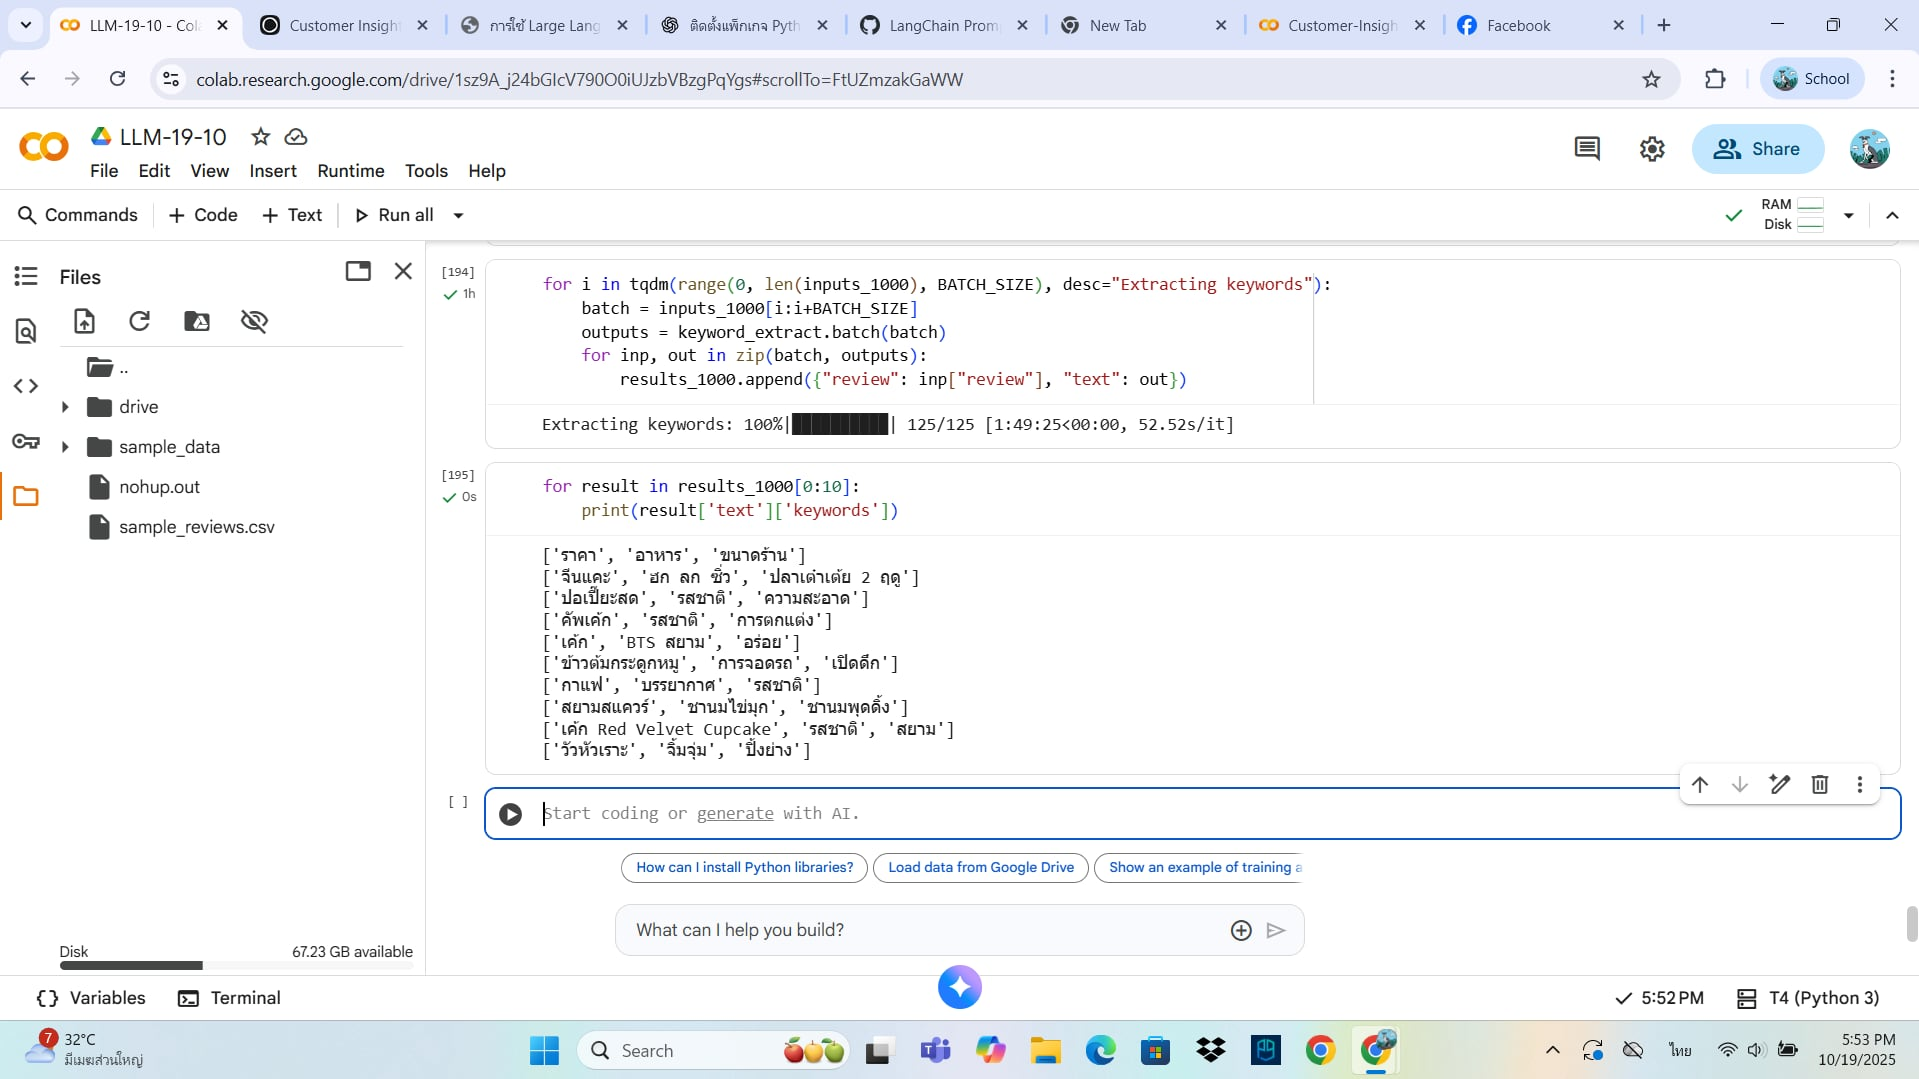

In [176]:
display(Image(filename="/content/drive/MyDrive/reviwe-dataset/1000.jpg"))

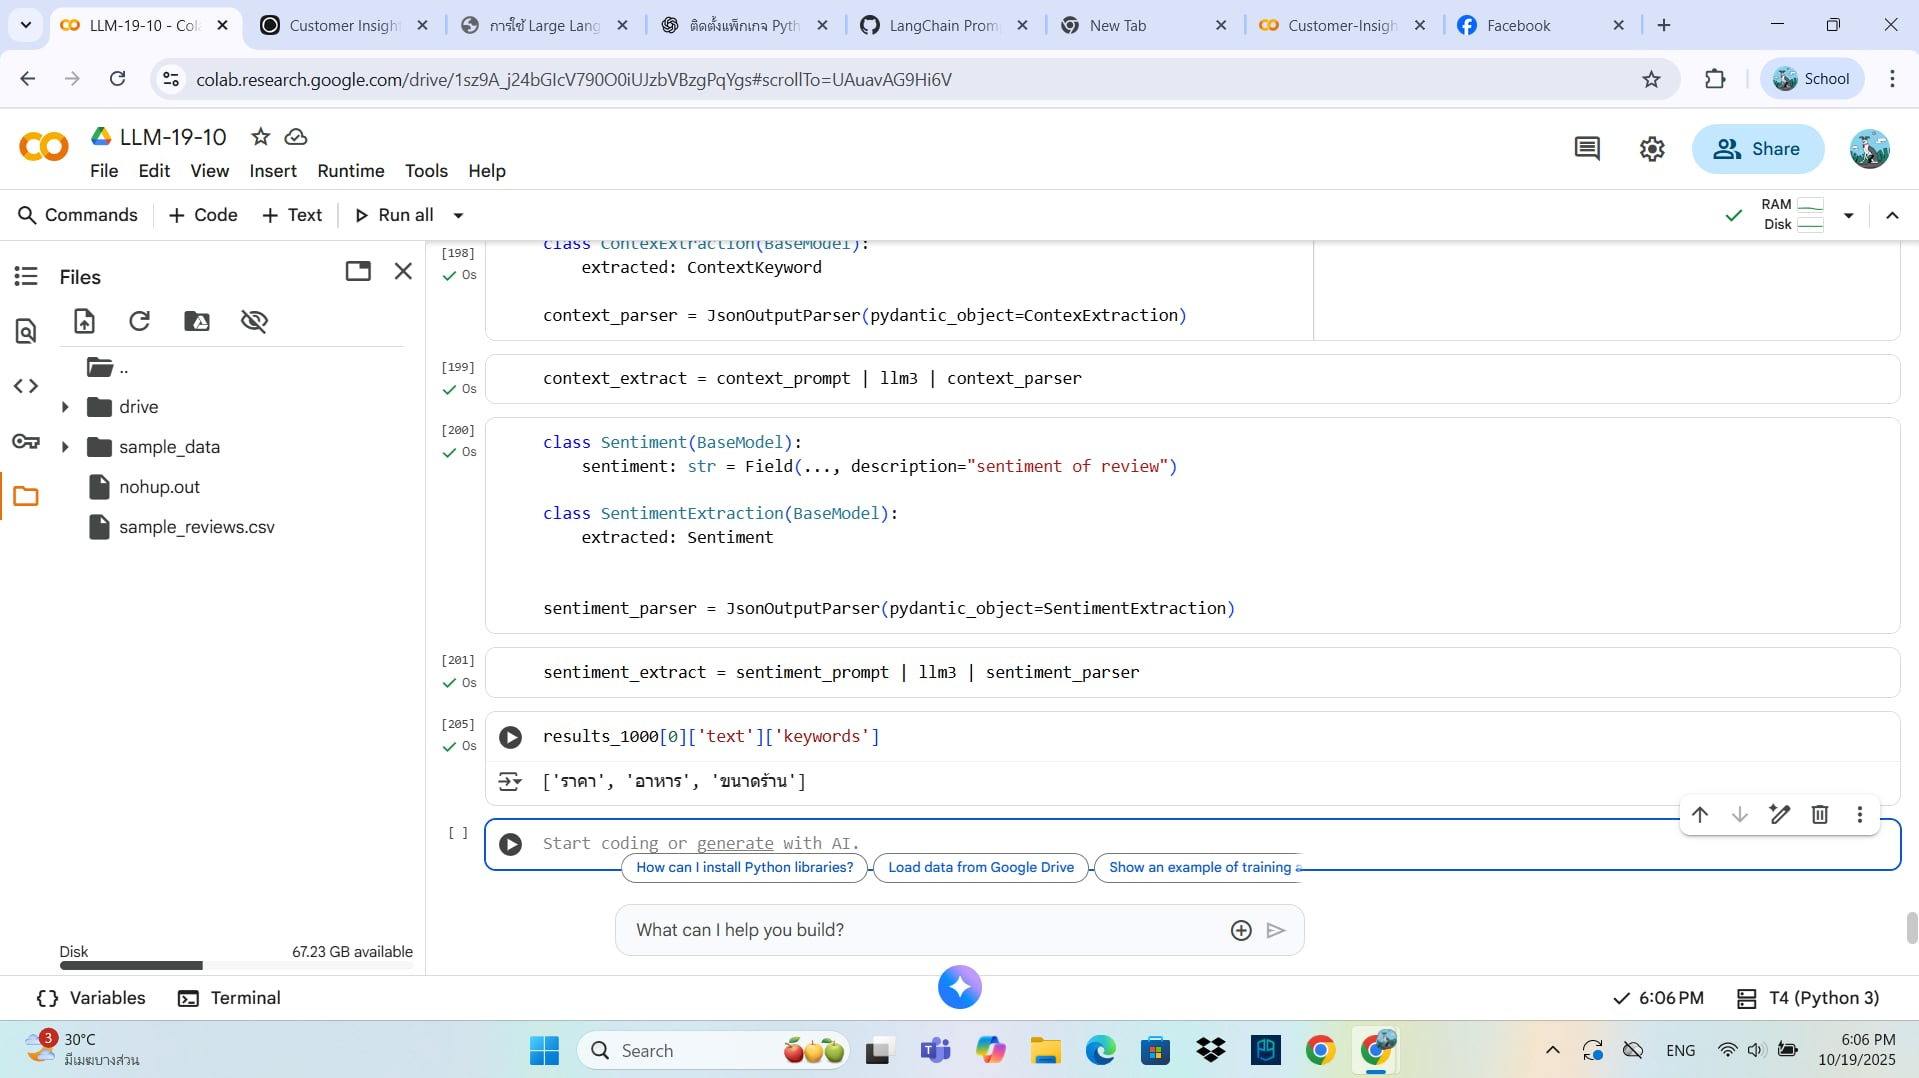

In [177]:
display(Image(filename="/content/drive/MyDrive/reviwe-dataset/1000-2.jpg"))